In [1]:
import numpy as np
import os
import pickle
import json
import matplotlib.pyplot as plt
from surface_level_analyses import LexicalSurfaceLevelAnalysis

In [2]:
train_set_analysis = LexicalSurfaceLevelAnalysis("training")
TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS:
    for i in range(1, 6):
        print(treatment, i)
        train_set_analysis.add_utterances(treatment, i)


generation_analysis = LexicalSurfaceLevelAnalysis("generation")
TREATMENTS = ['full', 'no_ji', 'no_ds', 'baseline']
for treatment in TREATMENTS:
    start_i = 1 if treatment in ['full', 'no_ji'] else 2
    for i in range(start_i, 5):
        print(treatment, i)
        generation_analysis.add_utterances(treatment, i)

full 1
full 2
full 3
full 4
full 5
no_ji 1
no_ji 2
no_ji 3
no_ji 4
no_ji 5
no_ds 1
no_ds 2
no_ds 3
no_ds 4
no_ds 5
baseline 1
baseline 2
baseline 3
baseline 4
baseline 5
full 1
full 2
full 3
full 4
no_ji 1
no_ji 2
no_ji 3
no_ji 4
no_ds 2
no_ds 3
no_ds 4
baseline 2
baseline 3
baseline 4


In [ ]:
human_human_analysis = LexicalSurfaceLevelAnalysis("human")
for i in range(1, 5):
    print('human', i)
    human_human_analysis.add_utterances('human', i)

In [ ]:
human_bot_analysis = LexicalSurfaceLevelAnalysis("human")
for treatment in TREATMENTS:
    for i in range(1, 5):
        print(treatment, i)
        human_bot_analysis.add_utterances(treatment, i, human_bot=True)

## Spatial reasoning: How do we fare when utterances contain terms relating to it?

In [ ]:
# What are the words we are interested in?
spatial_relationships = set()
for treatment in TREATMENTS + ['human']:
    for i in range(1, 5):
        if treatment == 'human':
            curr_tags = human_human_analysis.part_of_speech('human', i)[-1]['ADP']
        else:
            curr_treatment = treatment
            if treatment in ['no_ds', 'baseline'] and i == 1:
                curr_treatment = 'full' if treatment == 'no_ds' else 'no_ji'
            curr_tags = generation_analysis.part_of_speech(curr_treatment, i)[-1]['ADP']

        for tag in curr_tags:
            spatial_relationships.add(tag)

print(spatial_relationships)

In [ ]:
spatial_relationships = []
spatial_relationships = [
    'from', 'towards', 'thru', 'to', 'through', 'until', 'next', 'above', 'along', 'about', 'out', 'inside', 
    'behind', 'outside', 'forward', 'back', 'around', 'beneath', 'atop', 'up', 'apart', 'near', 'at',
    'below', 'into', 'onto', 'toward', 'past', 'upwards', 'before', 'within', 'against', 'between', 'beside',
    'on', 'after', 'by', 'over', 'across', 'down', 'opposite', 'underneath', 'in', 'under'
]
spatial_relationships += ['left', 'leftward', 'leftwards', 'right', 'rightward', 'rightwards']
spatial_relationships = set(spatial_relationships)

In [127]:
from collections import Counter

def accuracy_with_spatial_relationship(treatment, deployment_round, role):
    # Get the model gens
    if treatment == 'human':
        spacy_docs = human_human_analysis.get_round_utterances('human', deployment_round, human_human=True)
    else:
        if role == 'speaker':
            spacy_docs = train_set_analysis.get_round_utterances(treatment, deployment_round)
        else:
            spacy_docs = human_bot_analysis.get_round_utterances(treatment, deployment_round)

    result_dict = {'with' : Counter(), 'without' : Counter()}
    for game_id, game_dict in spacy_docs.items():
        for round_idx, (proc_doc, reward) in game_dict.items():
            correct = 1 if reward == 1 else 0
            key = 'with' if has_spatial_relationship(proc_doc) else 'without'
            result_dict[key]['total'] += 1
            result_dict[key]['correct'] += correct

    for key, key_dict in result_dict.items():
        key_dict['acc'] = 100 * key_dict['correct'] / key_dict['total']
    return result_dict

full [56.81470137825421, 67.08203530633438, 71.82835820895522, 74.6268656716418]
no_ji [45.954692556634306, 58.87353878852285, 65.50491510277033, 69.70149253731343]
no_ds [56.81470137825421, 61.56351791530945, 64.98649864986498, 67.03869047619048]
baseline [45.954692556634306, 57.28476821192053, 62.940140845070424, 62.14442013129103]
human [87.04761904761905, 87.44588744588745, 86.45720476706393, 85.48387096774194]


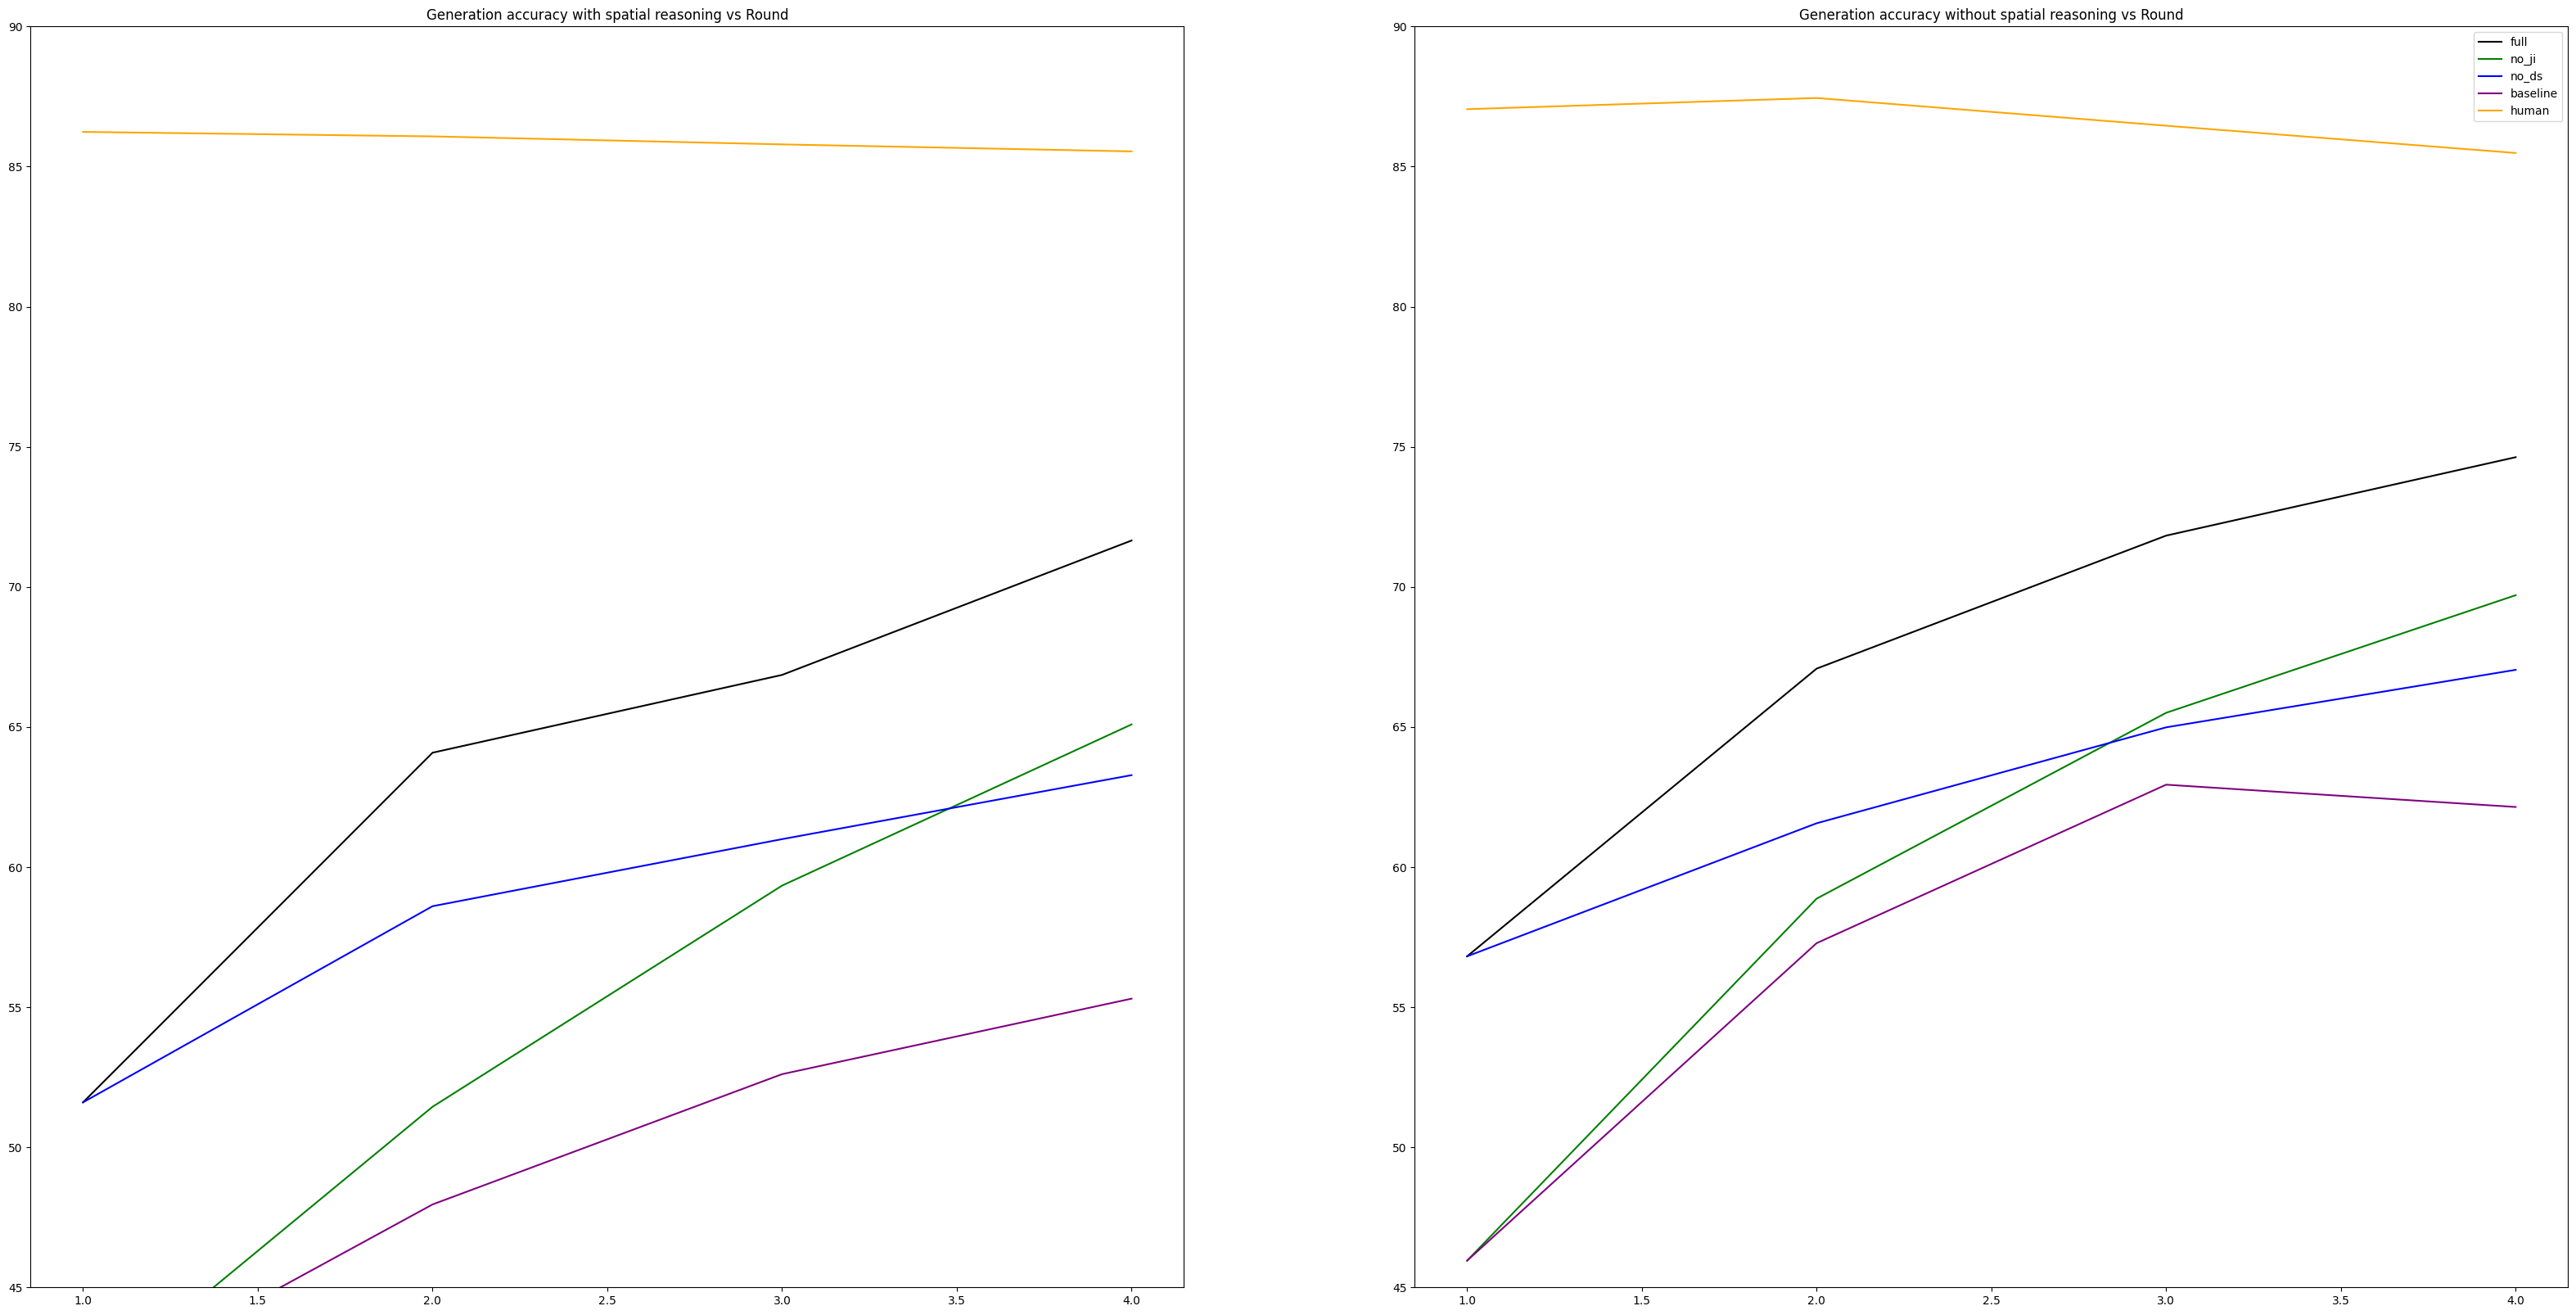

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 20))
axes[0].set_title('Generation accuracy with spatial reasoning vs Round')
axes[0].set_ylim([45, 90])

axes[1].set_title('Generation accuracy without spatial reasoning vs Round')
axes[1].set_ylim([45, 90])

role = 'listener'
for treatment in TREATMENTS + ['human']:
    x = list(range(1, 5))

    with_accs = []
    without_accs = []
    for i in x:
        result_dict = accuracy_with_spatial_relationship(treatment, i, role)
        with_accs.append(result_dict['with']['acc'])
        without_accs.append(result_dict['without']['acc'])

    axes[0].plot(x, with_accs, label=treatment, color=treatment_to_color[treatment])
    axes[1].plot(x, without_accs, label=treatment, color=treatment_to_color[treatment])

    print(treatment, without_accs)

plt.legend()
plt.show()